## 电影评论情感分类

In [1]:
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
from torch.utils.data import TensorDataset,DataLoader
import torch.optim as optim

In [2]:
# 设置超参数
LR = 0.001          # 学习率
BATCH_SIZE = 32     # 训练批量
EPOCH_NUM = 9       # 训练轮数
NUM_WORKERS = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def build_word2id(file, save_to_path=None):
    """
    :param file: word2id保存地址
    :param save_to_path: 保存训练语料库中的词组对应的word2vec到本地
    :return: None
    """
    word2id = {'_PAD_': 0}
    path = ['./data/train.txt', './data/validation.txt']

    for _path in path:
        with open(_path, encoding='utf-8') as f:
            for line in f.readlines():
                sp = line.strip().split()
                for word in sp[1:]:
                    if word not in word2id.keys():
                        word2id[word] = len(word2id)
    if save_to_path:
        with open(file, 'w', encoding='utf-8') as f:
            for w in word2id:
                f.write(w+'\t')
                f.write(str(word2id[w]))
                f.write('\n')

    return word2id


word2id = build_word2id('./data/word2id.txt')
print(len(word2id))

58954


In [4]:
def build_word2vec(filename, word2id, save_to_path=None):
    """
    :param filename: 预训练的word2vec.
    :param word2id: 语料文本中包含的词汇集.
    :param save_to_path: 保存训练语料库中的词组对应的word2vec到本地
    :return: 语料文本中词汇集对应的word2vec向量{id: word2vec}.
    """
    n_words = max(word2id.values()) + 1
    model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)
    word_vecs = np.array(np.random.uniform(-1., 1., [n_words, model.vector_size]))
    for word in word2id.keys():
        try:
            word_vecs[word2id[word]] = model[word]
        except KeyError:
            pass
    if save_to_path:
        with open(save_to_path, 'w', encoding='utf-8') as f:
            for vec in word_vecs:
                vec = [str(w) for w in vec]
                f.write(' '.join(vec))
                f.write('\n')
    return word_vecs

word2vec = build_word2vec('./data/wiki_word2vec_50.bin', word2id)
print(word2vec.shape)

(58954, 50)


In [5]:
def cat_to_id(classes=None):
    """
    :param classes: 分类标签；默认为0:pos, 1:neg
    :return: {分类标签：id}
    """
    if not classes:
        classes = ['0', '1']
    cat2id = {cat: idx for (idx, cat) in enumerate(classes)}
    return classes, cat2id


def load_corpus(path, word2id, max_sen_len=50):
    """
    :param path: 样本语料库的文件
    :return: 文本内容contents，以及分类标签labels(onehot形式)
    """
    _, cat2id = cat_to_id()
    contents, labels = [], []
    with open(path, encoding='utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            if not sp:
                continue
            label = sp[0]
            content = [word2id.get(w, 0) for w in sp[1:]]
            content = content[:max_sen_len]
            if len(content) < max_sen_len:
                content += [word2id['_PAD_']] * (max_sen_len - len(content))
            labels.append(label)
            contents.append(content)
    counter = Counter(labels)
    print('\tSamples num：%d' % (len(labels)))
    for w in counter:
        print('\tLabel= {}: {}'.format(w, counter[w]))

    contents = np.asarray(contents)
    labels = np.array([cat2id[l] for l in labels])

    return contents, labels

In [6]:
# 加载训练集与验证集
print('Loading Train Dataset...')
train_contents, train_labels = load_corpus('./data/train.txt', word2id, max_sen_len=50)
print('Loading Valid Dataset...')
val_contents, val_labels = load_corpus('./data/validation.txt', word2id, max_sen_len=50)

train_dataset = TensorDataset(torch.from_numpy(train_contents).type(torch.float),
                              torch.from_numpy(train_labels).type(torch.long))
valid_dataset = TensorDataset(torch.from_numpy(val_contents).type(torch.float),
                              torch.from_numpy(val_labels).type(torch.long))
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = NUM_WORKERS)

Loading Train Dataset...
	Samples num：19998
	Label= 1: 9999
	Label= 0: 9999
Loading Valid Dataset...
	Samples num：5629
	Label= 1: 2812
	Label= 0: 2817


In [7]:
# 设置模型参数
class CONFIG:
    update_w2v = True                   # 是否在训练中更新w2v
    vocab_size = word2vec.shape[0]      # 词汇量，与word2id中的词汇量一致
    n_class = 2                         # 分类数：分别为pos和neg
    embedding_dim = word2vec.shape[1]   # 词向量维度
    drop_prob = 0.5                     # dropout层，参数keep的比例
    num_filters = 128                   # 卷积层filter的数量
    kernel_size = 5                    # 卷积核的尺寸
    pretrained_embed = word2vec         # 预训练的词嵌入模型

In [8]:
class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()
        update_w2v = config.update_w2v
        vocab_size = config.vocab_size
        n_class = config.n_class
        embedding_dim = config.embedding_dim
        num_filters = config.num_filters
        kernel_size = config.kernel_size
        drop_prob = config.drop_prob
        pretrained_embed = config.pretrained_embed

        # 使用预训练的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embed))
        self.embedding.weight.requires_grad = update_w2v
        # 卷积层
        self.conv = nn.Conv2d(1,num_filters,(kernel_size,embedding_dim))
        # Dropout
        self.dropout = nn.Dropout(drop_prob)
        # 全连接层
        self.fc = nn.Linear(num_filters, n_class)

    def forward(self, x):
        x = x.to(torch.int64)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = F.relu(self.conv(x)).squeeze(3)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [9]:
config = CONFIG()
model = TextCNN(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [10]:
# train
from tqdm import tqdm

train_losses = []
train_counter = []
test_accuracy = [0.0]
test_counter = [i*len(train_dataloader.dataset) for i in range(EPOCH_NUM + 1)]

for epoch in range(0, EPOCH_NUM):
    model.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    loop = tqdm(train_dataloader, total = len(train_dataloader))
    for i, data in enumerate(loop):
        # prepare dataset
        length = len(train_dataloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward & backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        train_losses.append(sum_loss / (i + 1))
        if len(train_counter) == 0:
            train_counter.append(len(data))
        else:
            train_counter.append(train_counter[-1] + len(data))
        loop.set_description(f'Epoch [{epoch + 1}/{EPOCH_NUM}]')
        loop.set_postfix(loss = loss.item())

    scheduler.step()
    print('[epoch:%d] <Train> Loss: %.03f, Acc: %.3f%% ' % (epoch + 1, train_losses[-1], 100. * correct / total), end='\t')

    # validation
    with torch.no_grad():
        correct = 0
        total = 0
        for data in valid_dataloader:
            model.eval()
            vec, labels = data
            vec, labels = vec.to(device), labels.to(device)
            outputs = model(vec)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('<Valid> Acc: %.3f%%' % (100 * correct / total))
        test_accuracy.append(correct.item() / total)


torch.save(model.state_dict(), './' + str(EPOCH_NUM) +'epoch-model.pth')
torch.save(optimizer.state_dict(), './' + str(EPOCH_NUM) +'epoch-optimizer.pth')
print('\nTrain has finished, total epoch is %d, model saved.' % EPOCH_NUM)

Epoch [1/9]: 100%|██████████| 625/625 [00:10<00:00, 58.55it/s, loss=0.383] 


[epoch:1] <Train> Loss: 0.517, Acc: 73.832% 	<Valid> Acc: 79.819%


Epoch [2/9]: 100%|██████████| 625/625 [00:07<00:00, 84.95it/s, loss=0.486] 


[epoch:2] <Train> Loss: 0.350, Acc: 85.059% 	<Valid> Acc: 82.715%


Epoch [3/9]: 100%|██████████| 625/625 [00:07<00:00, 88.82it/s, loss=0.133]  


[epoch:3] <Train> Loss: 0.236, Acc: 90.849% 	<Valid> Acc: 83.549%


Epoch [4/9]: 100%|██████████| 625/625 [00:06<00:00, 91.57it/s, loss=0.0568] 


[epoch:4] <Train> Loss: 0.138, Acc: 95.175% 	<Valid> Acc: 83.656%


Epoch [5/9]: 100%|██████████| 625/625 [00:06<00:00, 90.91it/s, loss=0.162]  


[epoch:5] <Train> Loss: 0.095, Acc: 96.900% 	<Valid> Acc: 83.390%


Epoch [6/9]: 100%|██████████| 625/625 [00:06<00:00, 90.05it/s, loss=0.172]   


[epoch:6] <Train> Loss: 0.067, Acc: 97.955% 	<Valid> Acc: 83.443%


Epoch [7/9]: 100%|██████████| 625/625 [00:06<00:00, 92.07it/s, loss=0.0584]  


[epoch:7] <Train> Loss: 0.041, Acc: 98.905% 	<Valid> Acc: 83.532%


Epoch [8/9]: 100%|██████████| 625/625 [00:06<00:00, 93.34it/s, loss=0.0167]  


[epoch:8] <Train> Loss: 0.032, Acc: 99.210% 	<Valid> Acc: 83.407%


Epoch [9/9]: 100%|██████████| 625/625 [00:06<00:00, 92.07it/s, loss=0.00358] 


[epoch:9] <Train> Loss: 0.026, Acc: 99.310% 	<Valid> Acc: 83.390%

Train has finished, total epoch is 9, model saved.


C:\Users\Suxyuuu\AppData\Local\Temp\ipykernel_13416\1541606216.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


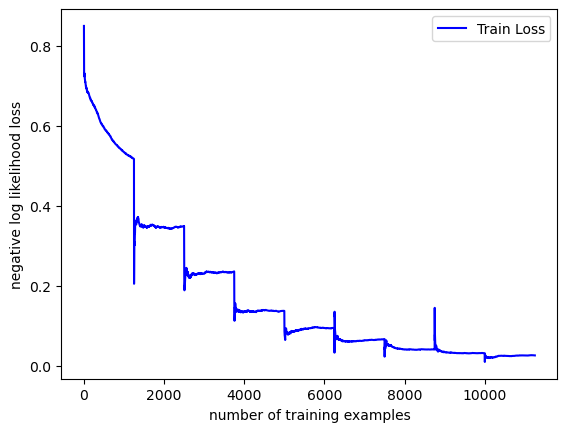

In [11]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('number of training examples')
plt.ylabel('negative log likelihood loss')
plt.legend(['Train Loss'], loc='upper right')
fig1.show()

C:\Users\Suxyuuu\AppData\Local\Temp\ipykernel_13416\2489387030.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


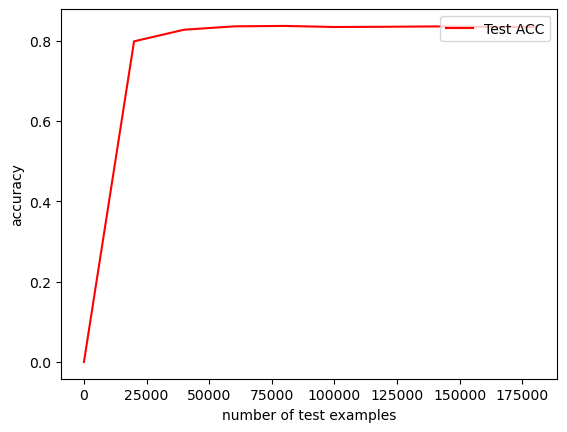

In [12]:
fig2 = plt.figure()
plt.plot(test_counter, test_accuracy, color='red')
plt.legend(['Test ACC'], loc='upper right')
plt.xlabel('number of test examples')
plt.ylabel('accuracy')
fig2.show()

In [13]:
# 加载测试集
print('Loading Test Dataset...')
test_contents, test_labels = load_corpus('./data/test.txt', word2id, max_sen_len=50)

test_dataset = TensorDataset(torch.from_numpy(test_contents).type(torch.float),
                              torch.from_numpy(test_labels).type(torch.long))
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = NUM_WORKERS)

Loading Test Dataset...
	Samples num：369
	Label= 1: 187
	Label= 0: 182


In [14]:
config = CONFIG()
model_path = './9epoch-model.pth'
model = TextCNN(config)
model.load_state_dict(torch.load(model_path))
model.to(device)

with torch.no_grad():
        correct = 0
        total = 0
        for data in tqdm(test_dataloader):
            model.eval()
            vec, labels = data
            vec, labels = vec.to(device), labels.to(device)
            outputs = model(vec)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('<Test> Acc: %.3f%%' % (100 * correct / total))
        test_accuracy.append(correct.item() / total)

100%|██████████| 12/12 [00:02<00:00,  5.24it/s]

<Test> Acc: 83.740%
